In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%tensorflow_version 2.x
## load modules
import cv2 as cv
import matplotlib.pyplot as plt
import os, time  
import numpy as np 
import imageio
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from google.colab.patches import cv2_imshow

print(tf.__version__)

2.8.2


In [ ]:
from google.colab.patches import cv2_imshow
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = '/content/drive/MyDrive/Colab/face_dataset/face_dataset/'
img_size = 64        # 이미지 사이즈
channels = 3 #흑백 1 컬러 3
noise_dim = 100
#이미지 읽기
def img_read(src,file):
    img = cv.cvtColor(cv.resize(cv.imread(src+file,cv.IMREAD_COLOR),(img_size,img_size)),cv.COLOR_BGR2RGB) # 컬러 이미지를 불러와서 64*64로 사이즈 변경 후 BGR -> RGB 변환
    return img
def get_data():
    #src 경로에 있는 파일 명을 저장합니다. 
    files = os.listdir(src)
    files_1 = files[:10000]
    X = []  

    # 경로와 파일명을 입력으로 넣어 확인하고 
    # 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다. 

    for file in files_1:
      
        X.append((img_read(src,file)-127.5)/127.5) 
    
    # Train set(80%), Test set(20%)으로 나누기 
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)
        
    # (x, 64, 64, 1) 차원으로 맞춰줌 
    #X_train = np.expand_dims(X_train, axis=3)
    #X_test = np.expand_dims(X_test, axis=3)
    X_train = np.array(X_train)
    X_test = np.array(X_test)


    return X_train, X_test
    print(files)

# 데이터 셋 불러옴 (이미지만 필요해서 y 라벨 필요 없음)
X_train, X_test = get_data()
print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (8000, 64, 64, 3)
X_test.shape = (2000, 64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


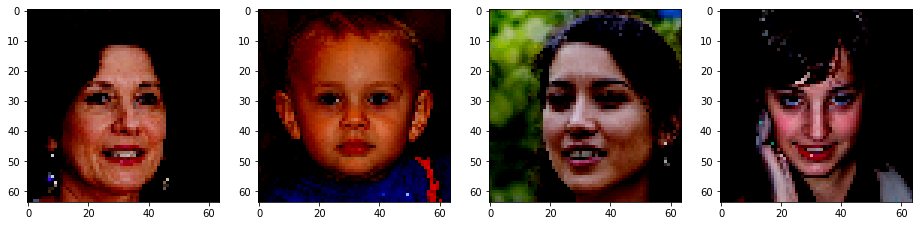

In [ ]:
# images 확인용
fig = plt.figure(figsize=(20,10))
nplot = 5
for i in range(1,nplot):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, :, :, :],cmap = plt.cm.bone)
plt.show()

In [ ]:
# ---------------------
#  Generator 모델 구성 (input : noise / output : image)
# ---------------------    
 
def build_generator():
    model = Sequential()
   
    model.add(layers.Dense(164, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(328))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(656))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))

    model.add(layers.Dense(np.prod(64*64*3), activation='tanh'))
    model.add(layers.Reshape((64,64,3)))
    # noise 텐서 생성, model에 noise 넣으면 이미지 나옴
    noise = Input(shape=(100,))
    img = model(noise)
    model.summary()
    return Model(noise,img) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 164)               16400     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 164)               0         
                                                                 
 batch_normalization (BatchN  (None, 164)              656       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 328)               54120     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 328)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 328)              1312      
 hNormalization)                                        

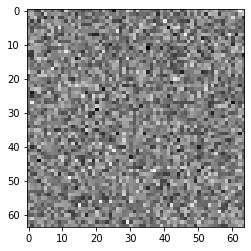

In [ ]:
# Optimizer
optimizer = Adam(0.0002, 0.5)

# generator 모델 생성과 컴파일(loss함수와 optimizer 설정)
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# 노이즈 만들어서 generator에 넣은 후 나오는 이미지 출력 (확인용)
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# plot_model(generator, show_shapes=True)

In [ ]:
# ---------------------
#  Discriminator 모델 구성 (input : image / output : 판별값(0에서 1사이의 숫자))
# ---------------------   
def build_discriminator():
    model = tf.keras.Sequential()
    img_shape = (img_size, img_size, channels)
    model.add(layers.Flatten(input_shape=img_shape))

    model.add(layers.Dense(656))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(328))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(164))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.summary()
    # 이미지 들어갈 텐서 생성, model에 넣으면 판별값 나옴
    img = Input(shape=img_shape)
    validity = model(img)
        
    return Model(img, validity) 

In [ ]:
# discriminator 모델 생성과 컴파일(loss함수와 optimizer 설정, accaracy 측정)
discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics   = ['accuracy'])

# image를 discriminator에 넣었을 때 판별값 나옴 (예시. 확인용)
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 656)               8061584   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 656)               0         
                                                                 
 dense_5 (Dense)             (None, 328)               215496    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 328)               0         
                                                                 
 dense_6 (Dense)             (None, 164)               53956     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 164)              

In [ ]:
# Combined Model
# 랜덤으로 만든 이미지로부터 학습해서 새로운 이미지를 만들어내는 generator의 데이터를 discriminator가 분류. 

z = layers.Input(shape=(100,), name="noise_input")
img = generator(z)

# 모델을 합쳐서 학습하기 때문에 발란스 때문에 discriminator는 학습을 꺼둠. 우리는 generator만 학습
discriminator.trainable = False

# discriminator에 이미지를 입력으로 넣어서 진짜이미지인지 가짜이미지인지 판별
valid = discriminator(img)

# generator와 discriminator 모델 합침. (노이즈가 인풋으로 들어가서 판별결과가 아웃풋으로 나오게)
# discriminator를 속이도록 generator를 학습
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise_input (InputLayer)    [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 64, 64, 3)         8364152   
                                                                 
 model_1 (Functional)        (None, 1)                 8331201   
                                                                 
Total params: 16,695,353
Trainable params: 8,361,856
Non-trainable params: 8,333,497
_________________________________________________________________


In [ ]:
def train(epochs, batch_size=128, sample_interval=50):
              
        # 정답으로 사용 할 매트릭스. valid는 1, fake는 0
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        history = []
        for epoch in range(epochs):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # batch_size만큼 이미지와 라벨을 랜덤으로 뽑음
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # Sample noise 생성(batch_size만큼)
            noise = np.random.normal(0, 1, (batch_size, 100))
            
            # noise를 generator에 넣어서 fake image 이미지 생성
            gen_imgs = generator.predict(noise)
            
            # discriminator를 학습함. 진짜 이미지는 1이 나오게, 가짜 이미지는 0이 나오게
            # discriminator가 이미지를 판별한 값과 valid와 fake가 
            # 각각 같이 들어가서 binary_crossentropy으로 계산되어 업데이트함.
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            
            # real을 넣었을 때와 fake를 넣었을 때의 discriminator의 loss값과 accracy값의 평균을 구함.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            
            # noise 생성
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            
            # noise가 들어가서 discriminator가 real image라고 판단하도록 generator를 학습
            g_loss = combined.train_on_batch(noise, valid)

            history.append({"D":d_loss[0],"G":g_loss})

            # sample_interval(1000) epoch 마다 loss와 accuracy와 이미지 출력
            if epoch % sample_interval == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
                sample_images(epoch)
            #if epoch % sample_interval/5 == 0:
                

        return(history)

In [ ]:
 # 이미지 출력
def sample_images(epoch):
        r, c = 4, 4
        noise = np.random.normal(0, 1, (r * c, noise_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5


        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:], cmap=plt.cm.bone)
                axs[i,j].axis('off')
                cnt += 1

#         plt.close()

In [ ]:
# GAN 실행
history=train(epochs=2001, batch_size=256, sample_interval=40)

Output hidden; open in https://colab.research.google.com to view.

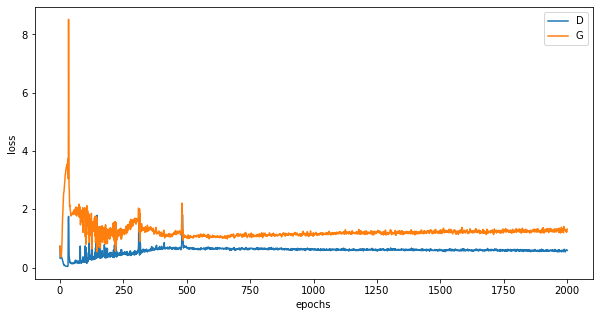

In [ ]:
# summarize history for loss
import pandas as pd 
hist = pd.DataFrame(history)
plt.figure(figsize=(10,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

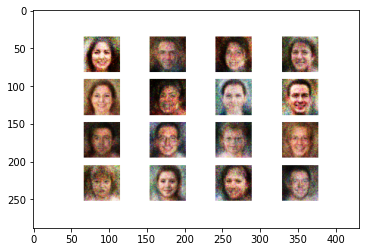

In [ ]:
gen_image_last = cv.cvtColor((cv.imread('image_at_epoch_2000.png')),cv.COLOR_BGR2RGB)
plt.imshow(gen_image_last)

In [ ]:
from PIL import Image
anim_file = 'gan.gif'

# Create the frames
frames = []
imgs = glob.glob("image*.png")
imgs = sorted(imgs)
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save(anim_file, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=2, loop=0)

In [ ]:
#GIF 추출
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>